# Классификатор текстов
Самостоятельно обучить классификатор текстов на примере 20newsgroups
На примере 20 newsgroups попробовать разные параметры для сверток для классификации текстов

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

In [ ]:
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

Токенизация текста

In [ ]:
count_vect = CountVectorizer(analyzer='word', stop_words='english', max_df=0.5, min_df=10)
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_test_counts = count_vect.transform(twenty_test.data)
X_train_counts.shape, X_test_counts.shape

((2257, 4536), (1502, 4536))

определим tf меру

In [ ]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
X_train_tfidf.shape, X_test_tfidf.shape

((2257, 4536), (1502, 4536))

In [ ]:
class Dataset(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, target, used_length):
        self.base_dataset = init_dataset
        self.target = target
        self._length = used_length

    def __len__(self):
        return self.base_dataset.shape[0]

    def encode_sentence(self, dataset):
        encoded = np.zeros(self._length, dtype=int)
        length = min(self._length, dataset.shape[0])
        encoded[:length] = (dataset*1000)[:length]
        return encoded, length

    def __getitem__(self, idx):

        encoded, length = self.encode_sentence(self.base_dataset[idx].tocoo().data)
        
        return torch.tensor(encoded, dtype=torch.long), \
               torch.tensor(self.target[idx], dtype=torch.long),\
               torch.tensor(length, dtype=torch.long)

In [ ]:
batch_size=128
train = torch.utils.data.DataLoader(Dataset(X_train_tfidf, twenty_train.target, batch_size),
                                    batch_size=batch_size,
                                    shuffle=True)
test = torch.utils.data.DataLoader(Dataset(X_test_tfidf, twenty_test.target, batch_size),
                                    batch_size=batch_size,
                                    shuffle=False)

In [ ]:
class Net(nn.Module):
    def __init__(self, vocab_size=71699, embedding_dim = 128, out_channel = 128, num_classes = 2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        #                       B  F  L         
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        return output
    
    def predict(self, x):
        return F.softmax(self.forward(x))

In [ ]:
model = Net(vocab_size=X_test_tfidf.tocoo().row.shape[0],
            embedding_dim = batch_size, 
            out_channel = batch_size, 
            num_classes = len(categories))


optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


In [ ]:
model.to(device)
model.train()
train_loss = []
test_loss = []
for epoch in tqdm(range(10)):  
    model.train()
    loss_accumed = 0
    for i,  (x, y, _) in enumerate(train, 0):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        outputs = model(x)
        loss = criterion(outputs, y)
        loss_accumed += loss
        loss.backward()
        optimizer.step()
    
    train_loss.append(float(loss_accumed/len(train)))
        
    model.eval()
    loss_accumed = 0
    for x, y, lengths in test:
       
        x = x.to(device)
        y = y.to(device)
        output = model(x.to(device))
        loss = criterion(output, y.to(device))
        loss_accumed += loss

    test_loss.append(float(loss_accumed/len(test)))

print('Training is finished!')

100%|██████████| 10/10 [00:09<00:00,  1.06it/s]

Training is finished!


Populating the interactive namespace from numpy and matplotlib


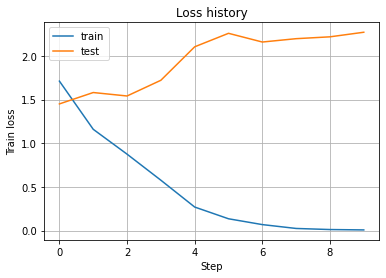

In [ ]:
import matplotlib.pyplot as plt
%pylab inline
plt.title('Loss history')
plt.grid(True)
plt.ylabel('loss')
plt.xlabel('Step')
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend();